In [64]:
import torchphysics as tp
from torchphysics.utils import grad, laplacian
import torch
import pytorch_lightning as pl
import math

## Spaces and Samplers

In [65]:
# coordinates
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')

# fields
U = tp.spaces.R2('u') # velocity
B = tp.spaces.R1('b') # temperature
P = tp.spaces.R1('p') # pressure

# domain
omega = tp.domains.Parallelogram(X, origin=[0, -1], corner_1=[0, 1], corner_2=[2 * math.pi, -1])
time = tp.domains.Interval(T, 0, 20)
domain = time * omega

In [66]:
def bottom_filter(x, t):
    return x[..., 1] == -1

def top_filter(x, t):
    return x[..., 1] == 1

def sides_filter(x, t):
    return (x[..., 0] == 0) | (x[..., 0] == 2 * math.pi)

# sampler
inner_sampler       = tp.samplers.RandomUniformSampler(domain, n_points=25000).make_static(resample_interval=200)
bc_bottom_sampler   = tp.samplers.RandomUniformSampler(omega.boundary*time, filter_fn=bottom_filter, n_points=2_000).make_static(resample_interval=200)
bc_top_sampler      = tp.samplers.RandomUniformSampler(omega.boundary*time, filter_fn=top_filter, n_points=2_000).make_static(resample_interval=200)
bc_sides_sampler    = tp.samplers.RandomUniformSampler(omega.boundary*time, filter_fn=sides_filter, n_points=2_000).make_static(resample_interval=200)

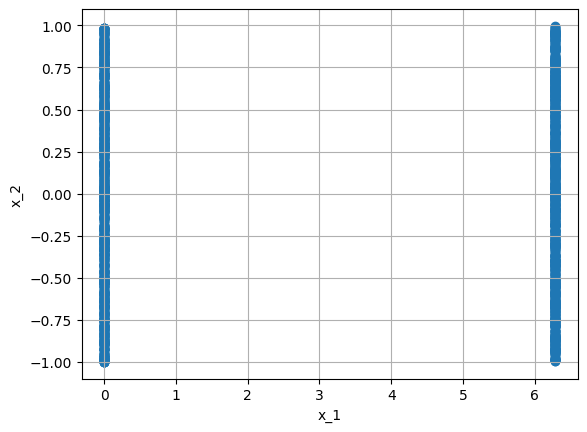

In [67]:
plot = tp.utils.scatter(X, bc_sides_sampler)

## Model

In [68]:
model = tp.models.FCN(input_space=T*X, output_space=U*B*P, hidden=[256]*5)

## PDE conditions

In [69]:
# parameters
Ra = 1000000
Pr = 0.7
nu = torch.sqrt(torch.tensor(Pr/Ra))
kappa = 1./torch.sqrt(torch.tensor(Pr*Ra))

In [70]:
# TODO split into single conditions
def momentum_residual(p, b, u, x, t):
    return grad(u, t) + (torch.pow(u, 2) * grad(u, x)) + grad(p, x) - nu * laplacian(u, x) + b

def continuity_residual(u, x, t):
    return laplacian(u, x)

def buoyancy_residual(b, u, x, t):
    return grad(b, t) + u * grad(b, x) - kappa * laplacian(b, x)

momentum_cond = tp.conditions.PINNCondition(model, inner_sampler, momentum_residual)
continuity_cond = tp.conditions.PINNCondition(model, inner_sampler, continuity_residual)
buoyancy_cond = tp.conditions.PINNCondition(model, inner_sampler, buoyancy_residual)

In [ ]:
def bc_T_bottom_residual(b, x):
    return b - 2

def bc_T_top_residual(b, x):
    return b - 1

def bc_noslip_residual(u, x):
    return u

bc_T_bottom_condition = tp.conditions.PINNCondition(model, bc_bottom_sampler, bc_T_bottom_residual)
bc_T_top_condition = tp.conditions.PINNCondition(model, bc_top_sampler, bc_T_top_residual)
bc_noslip_condition = tp.conditions.PINNCondition(model, bc_bottom_sampler+bc_top_sampler+bc_sides_sampler, bc_noslip_residual)

#TODO Periodic BCs

In [ ]:
# Initial conditions
# TODO

In [72]:
optim = tp.OptimizerSetting(torch.optim.LBFGS, lr=0.1, optimizer_args={"max_iter" : 5})
solver = tp.solver.Solver([bc_T_bottom_condition, bc_T_top_condition, bc_noslip_condition, momentum_cond, continuity_cond, buoyancy_cond],
                           optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="auto",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=400, 
                     logger=False,
                     enable_checkpointing=False)
trainer.fit(solver)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 265 K  | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.061     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
/Users/tmarkmann/sail/RBC-PINN-Surrogate/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/tmarkmann/sail/RBC-PINN-Surrogate/.venv/lib/python3.11/site-packages/pytorch_lig

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined